# Chaîne de traitement d'INCEpTION au NER dans le cadre de NER4Archives

Version : python 3.7

Dernière MAJ : 22/10/2021

Auteur : Lucas Terriel

Ce notebook à pour but de présenter une chaîne de traitement opérationnel pour traiter le corpus de NER4Archives après sa récupération dans la plateformme d'annotation INCEpTION : 

1) Fusion (**merge**) des fichiers annotés et corrigés CONLL en un unique *dataset*

2) Retokenisation (optionnel) contrôlée du *dataset* (*log*)

3) Mélange (**shuffling**) et Sérialisation (**splitting**) du *dataset* en *samples* : un corpus n2 (set entraînement /test) et corpus n3 (set entraînement / test / validation)

4) Normalisation des fichiers en sortie

5) Export

## Détail

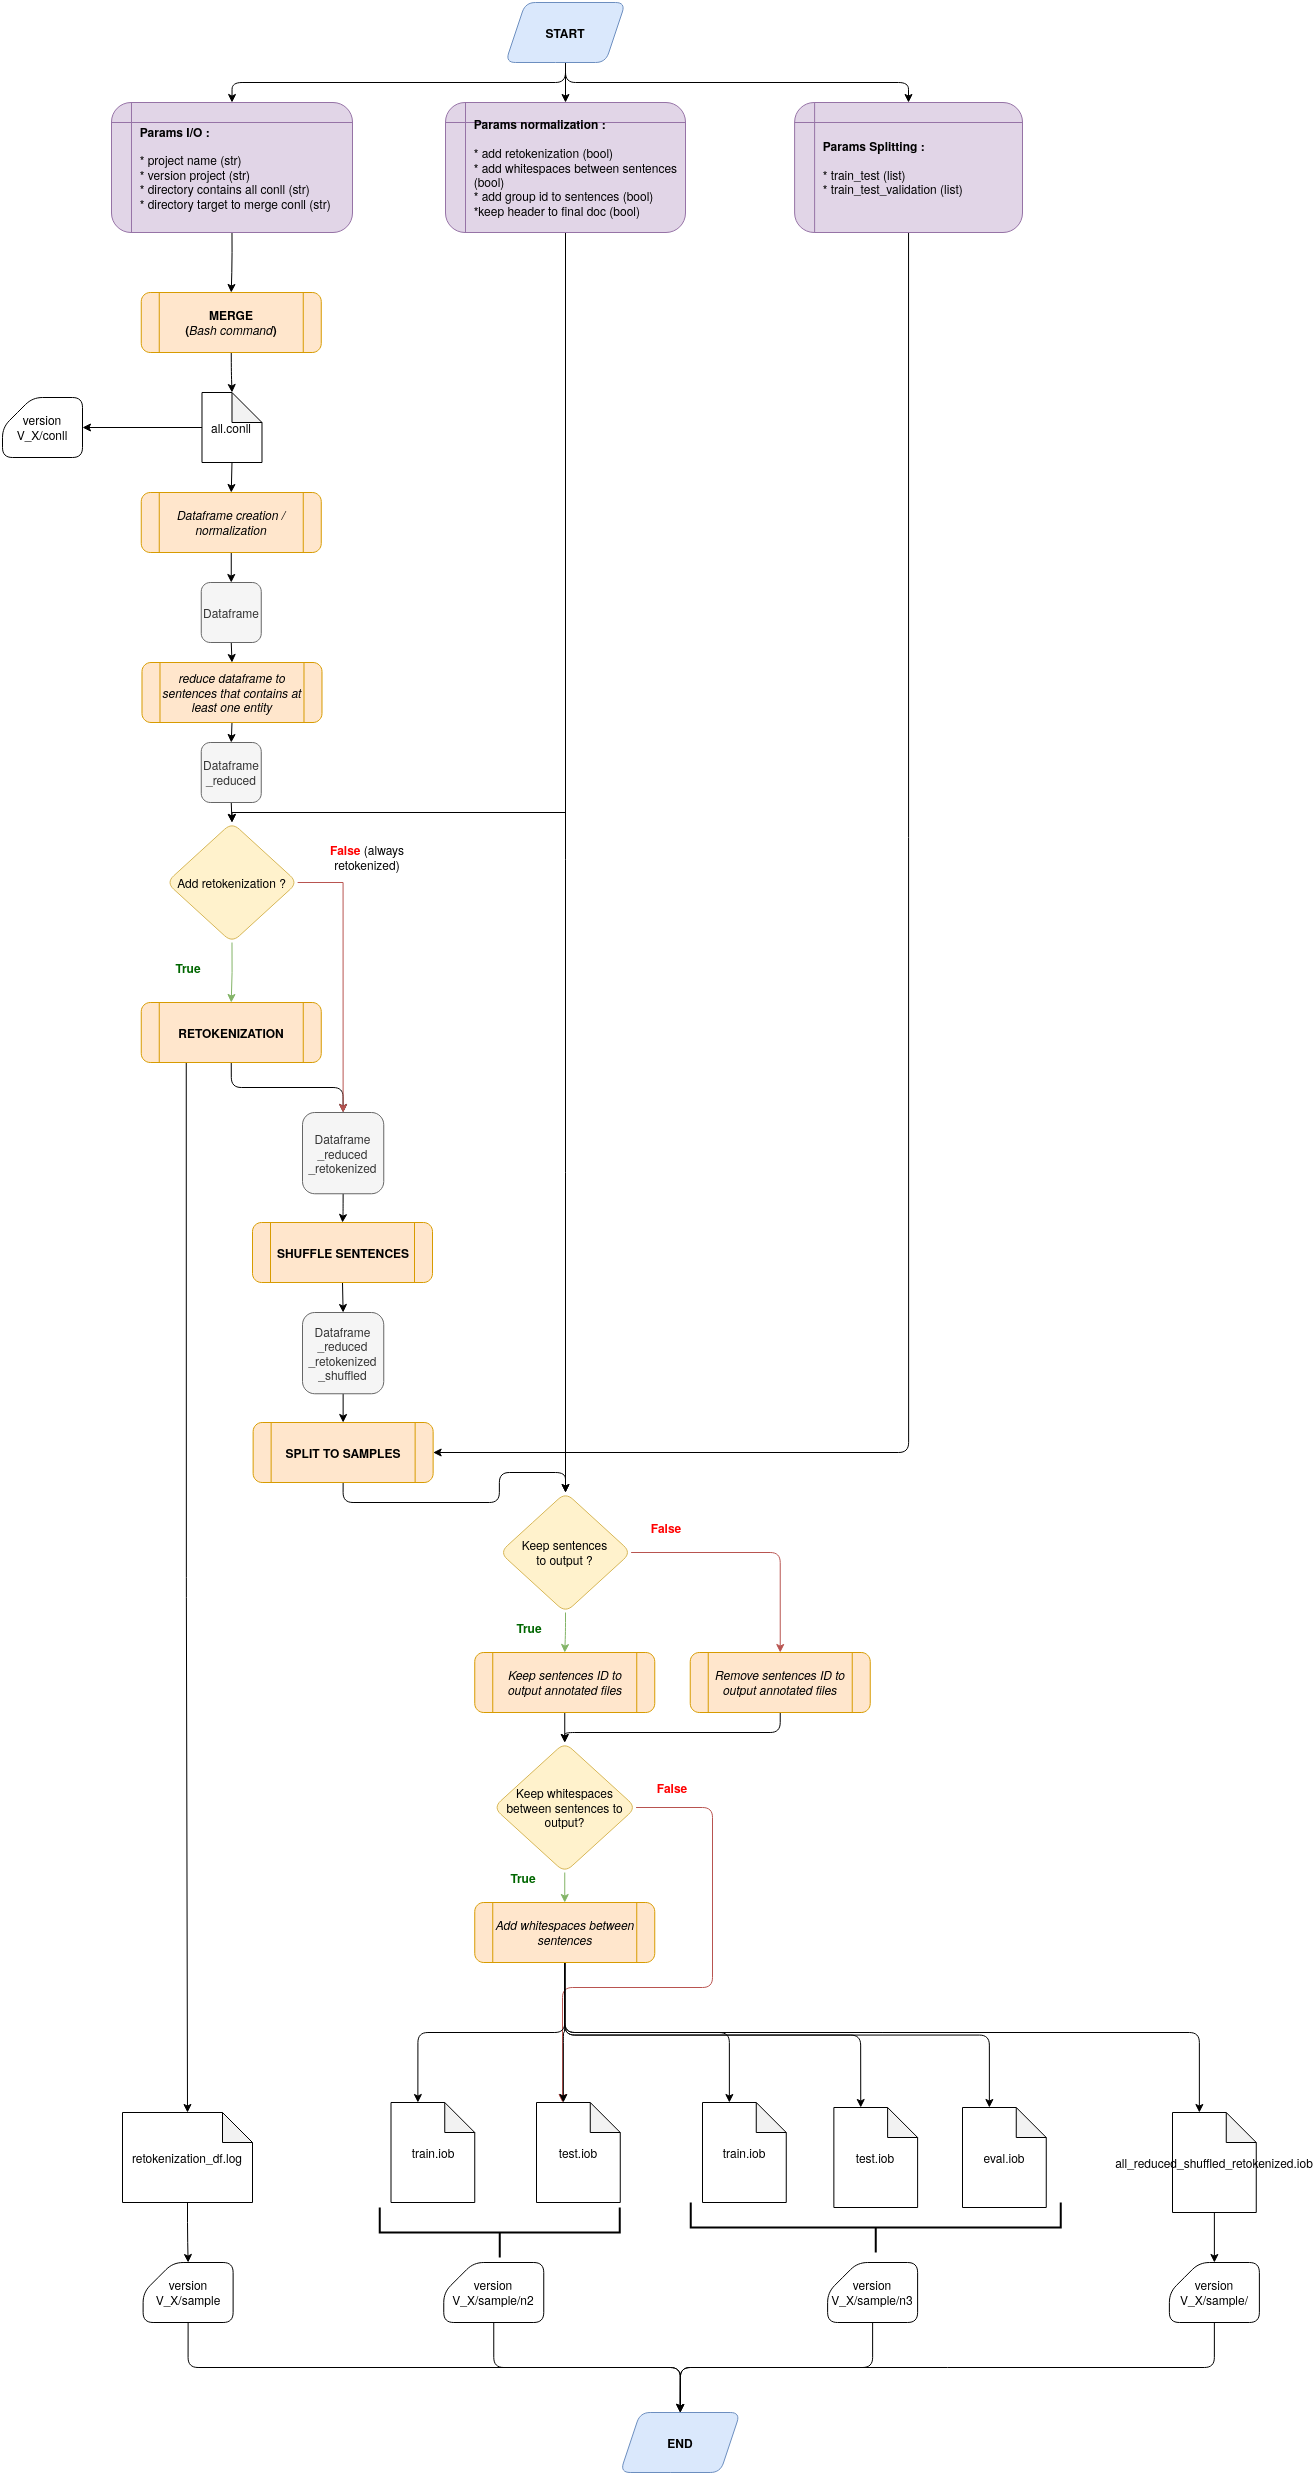

In [1]:
# image : '../documentation/algo_merge_retok_split_df.drawio.png'
from IPython.display import Image
Image(filename='../documentation/algo_merge_retok_split_df.drawio.png')

<!--<img src="../documentation/algo_merge_retok_split_df.drawio.png" />
![algo](<../documentation/algo_merge_retok_split_df.drawio.png>) -->

In [2]:
import datetime
from itertools import chain
import os
import random
import re

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Renseigner les variables I/O et les paramètres

* Paramètres I/O

In [3]:
name_project = "n4a"
version = "v1"
input_dir_conlls = f"../EAD_release/{version}_{name_project}/conll/annotations/"
output_all_conll =  f"../EAD_release/{version}_{name_project}/conll/curated_{version}_{name_project}_all.conll"
dir_sample = f"../EAD_release/{version}_{name_project}/sample/" 

* Paramètres de normalisation de la sortie

In [4]:
# Ajouter des espaces entre les phrases en sortie (True / False) :
add_whitespace_between_sentences = False
# Conserver les id de phrases en sortie (True / False) :
keep_sentences = False
# Conserver l'en-tête en sortie (True / None) :
keep_header = None

# Appliquer la retokenisation sur les fichiers (True/False) :
is_retokenization = False

# Sortie entière (True/False) :
is_all = True
# Sortie sérialisée (True/False) : 
is_split = True

* Paramètres de sérialisation

In [5]:
train_test = [0.8, 0.2]
# autres valeurs possible : [0.8, 0.1, 0.1]
train_test_validation  = [0.6, 0.2, 0.2]

=> Execution de toute les cellules possible

### Fusion des fichiers annotés et corrigés en un unique fichier CONLL (*merge*)

In [6]:
!cat $input_dir_conlls*.conll >> $output_all_conll

### Normalisation des lignes du CONLL (sortie INCEpTION) et création d'une structure de données pour la *dataframe*

In [7]:
def conll_to_dataframe(all_conll_file):
    with open(output_all_conll, "r", encoding="utf-8") as f:
        conll = f.read()

    to_dataframe = []

    counter = 1
    for row in conll.splitlines():
        pair = row.split(" ")
        if len(pair) == 1:
            # if pair == [""] is breakline
            association = ('break', 'break', 'break')
            counter += 1
            to_dataframe.append(association)
        else:
            mention = pair[0].strip()
            label = pair[1].strip()
            if mention != "":
                association = (counter, pair[0].strip(), pair[1].strip())
                to_dataframe.append(association)
    return to_dataframe

conll_to_df = conll_to_dataframe(output_all_conll)

### Création de la *dataframe*

In [8]:
# creation de la dataframe principal 
df = pd.DataFrame(conll_to_df, columns =['Sentence', 'Mention', 'Tag'])
# convertion des valeurs "mention" en string
df = df.astype(str)
# visualisation
df[0:50]

Sentence       Mention             Tag
0         1            JJ               O
1         1             /               O
2         1             /               O
3         1           226               O
4         1             /               O
5         1             A               O
6     break         break           break
7         2           465               O
8     break         break           break
9         3     Vincennes      B-LOCATION
10        3             .               O
11    break         break           break
12        4  Confirmation               O
13        4           des               O
14        4    privilèges               O
15        4            de               O
16        4            la               O
17        4   villed'Aire               O
18        4             1               O
19        4             ,               O
20        4            au               O
21        4     bailliage  B-ORGANISATION
22        4            d'  I-ORGANISATION
23        4        Amiens  I-ORGANISATION
24        4             (               O
25        4            cf               O
26        4             .               O
27        4         infra               O
28        4             ,               O
29        4            JJ               O
30        4           230               O
31        4             ,               O
32        4             n               O
33        4             °               O
34        4             4               O
35        4             ,               O
36        4            97               O
37        4             )               O
38        4             .               O
39    break         break           break
40        5             (               O
41        5           Fol               O
42        5             .               O
43        5           286               O
44        5             ,               O
45        5             n               O
46        5             °               O
47        5           465               O
48        5             )               O
49        5             .               O

### Réduction du CONLL fusionné aux seules lignes contenant des entités nommées

In [9]:
# suppression des phrases qui ne contiennent pas d'entités nommées (préfixées en IOB)
empty_sentences = df.loc[((df.Tag.str.startswith('B-') | df.Tag.str.startswith('I-')) & df.Tag.str.contains('O')), 'Sentence']
df_reduced = df.loc[df['Sentence'].isin(empty_sentences)]

df = df[~df.Sentence.str.contains("break")]

# vérification
df_reduced[0:50]

Sentence          Mention             Tag
9         3        Vincennes      B-LOCATION
10        3                .               O
12        4     Confirmation               O
13        4              des               O
14        4       privilèges               O
15        4               de               O
16        4               la               O
17        4      villed'Aire               O
18        4                1               O
19        4                ,               O
20        4               au               O
21        4        bailliage  B-ORGANISATION
22        4               d'  I-ORGANISATION
23        4           Amiens  I-ORGANISATION
24        4                (               O
25        4               cf               O
26        4                .               O
27        4            infra               O
28        4                ,               O
29        4               JJ               O
30        4              230               O
31        4                ,               O
32        4                n               O
33        4                °               O
34        4                4               O
35        4                ,               O
36        4               97               O
37        4                )               O
38        4                .               O
54        7                1               O
55        7                .               O
56        7  Aire-sur-la-Lys      B-LOCATION
57        7                ,               O
58        7    Pas-de-Calais      B-LOCATION
59        7                ,               O
60        7              arr  B-ORGANISATION
61        7                .  I-ORGANISATION
62        7               de  I-ORGANISATION
63        7       Saint-Omer  I-ORGANISATION
64        7                .               O
68        9            Paris      B-LOCATION
69        9                .               O
71       10          Lettres               O
72       10               de               O
73       10        rémission               O
74       10        accordées               O
75       10                à               O
76       10             Jean        B-PERSON
77       10               Le        I-PERSON
78       10            Douch        I-PERSON

### Retokenisation de la dataframe

* Préparation des fonctions de *preprocessing* des tokens

In [10]:
class Retokenization:
    def __init__(self, mention, split_apos=True, unprintable_char=False) -> None:
        self.mention = mention
        self.split_apos = split_apos
        self.unprintable_char = unprintable_char
        self.tokens = self.split_off_apostrophes()
    
    def split_off_apostrophes(self):
        if "'" in self.mention and len(self.mention) > 1:
            if not re.search(r"[\-]", str(self.mention)) and not re.search(r"[\w]{2,}['][\w]+", str(self.mention)):
                inter = re.split(r"(\w')", self.mention)
                tokens = [tok for tok in inter if tok != '']
                return tokens
            else:
                return self.mention.split()
        else:
            return self.mention.split()
    
    # ajout de fonctions de retokenisation ici ...

* Application des fonctions de *preprocessing* des tokens sur la dataframe

In [11]:
if is_retokenization:
    mentions = df_reduced['Mention'].apply(lambda mention : Retokenization(mention).tokens).fillna(value='_')
    mentions_not_reduced = df['Mention'].apply(lambda mention : Retokenization(mention).tokens).fillna(value='_')
    print(mentions[0:50])

* Génération d'un log de contrôle pour la retokenisation

In [12]:
if is_retokenization:
    # retokenization log 

    mentions_log = mentions[mentions.apply(len) > 1]
    length_mentions = len(mentions_log)
    now = datetime.datetime.now()

    name_log = dir_sample + "retokenization_df.log"
    log = open(name_log, mode="w",  encoding='utf-8')
    log.write(f'[INFO] RETOKENIZATION DF PROCESS LOG - {now} - number of tokens processed : {length_mentions}\n')
    log.close()

    mentions_log.to_csv(name_log, index=True, sep=' ', header=None, mode='a')

* création de la nouvelle dataframe retokénisé

In [13]:
if is_retokenization:
    print('Add retokenization process to dataframe ...')

    df_reduced_retokenized = pd.DataFrame({
    
    'Sentence' : df_reduced['Sentence'].values.repeat(mentions.str.len()),
    'Mention' : list(chain.from_iterable(mentions.tolist())),
    'Tag' : df_reduced['Tag'].values.repeat(mentions.str.len())

    })

    df_notreduced_retokenized = pd.DataFrame({
    
    'Sentence' : df['Sentence'].values.repeat(mentions_not_reduced.str.len()),
    'Mention' : list(chain.from_iterable(mentions_not_reduced.tolist())),
    'Tag' : df['Tag'].values.repeat(mentions_not_reduced.str.len())

    })

    # Post-traitment des préfixes IOB manquants :
    m1 = df_reduced_retokenized['Tag'].eq('O')
    m2 = m1 & df_reduced_retokenized['Tag'].shift(-1).str.startswith('I-')
    add_tag = df_reduced_retokenized['Tag'].shift(-1).str.replace(r"\w[-](\w+)", r"\1", regex=True)

    m1_not = df_notreduced_retokenized['Tag'].eq('O')
    m2_not = m1_not & df_notreduced_retokenized['Tag'].shift(-1).str.startswith('I-')
    add_tag_not = df_notreduced_retokenized['Tag'].shift(-1).str.replace(r"\w[-](\w+)", r"\1", regex=True)

    df_reduced_retokenized['Tag'] = np.select([m2], ['B-' + add_tag], df_reduced_retokenized['Tag'])
    df_notreduced_retokenized['Tag'] = np.select([m2_not], ['B-' + add_tag_not], df_notreduced_retokenized['Tag'])

    # Visualisation
    print(df_reduced_retokenized[0:20])
    #print(df_notreduced_retokenized[0:20])
else:
    print('Retokenization is always effective in dataframe ...')
    df_reduced_retokenized = df_reduced
    df_notreduced_retokenized = df
    # Visualisation
    print(df_reduced_retokenized[0:20])

Retokenization is always effective in dataframe ...
   Sentence       Mention             Tag
9         3     Vincennes      B-LOCATION
10        3             .               O
12        4  Confirmation               O
13        4           des               O
14        4    privilèges               O
15        4            de               O
16        4            la               O
17        4   villed'Aire               O
18        4             1               O
19        4             ,               O
20        4            au               O
21        4     bailliage  B-ORGANISATION
22        4            d'  I-ORGANISATION
23        4        Amiens  I-ORGANISATION
24        4             (               O
25        4            cf               O
26        4             .               O
27        4         infra               O
28        4             ,               O
29        4            JJ               O


### *Shuffling* de la dataframe

In [14]:
def shuffle_dataframe(df, group_target='Sentence'):
    groups = [group for _, group in df.groupby(group_target)]
    random.shuffle(groups)
    df_shuffle = pd.concat(groups).reset_index(drop=True)
    return df_shuffle

df_reduced_retokenized_shuffled = shuffle_dataframe(df_reduced_retokenized)

# Visualisation
#df_reduced_retokenized_shuffled[0:50]

### *Splitting* dataframe en un corpus en version n2 : entraînement / test  et un corpus en version n3 : entraînement / test / évaluation 

In [15]:
def split_train_test(df, values):
    # shuffle sur False car df déjà mélangé
    train, test = train_test_split(df, test_size=values[1], random_state=42, shuffle=False)
    return train, test

def split_train_test_validation(df,values):
    train, test, validate = np.split(df, 
                       [int(values[0]*len(df)), int(.8*len(df))])

    return train, test, validate

if is_split:
    n2_train, n2_test = split_train_test(df_reduced_retokenized_shuffled, train_test)
    n3_train, n3_test, n3_validation = split_train_test_validation(df_reduced_retokenized_shuffled, train_test_validation)

    # statistiques 
    total_original = len(df_reduced_retokenized_shuffled)
    n2_train_stats = (len(n2_train) / total_original) 
    n2_test_stats = (len(n2_test) / total_original)
    n3_train_stats = (len(n3_train) / total_original)
    n3_test_stats = (len(n3_test) / total_original)
    n3_validation_stats = (len(n3_validation) / total_original)
    print(f"""
            === Statistics sample stratification ===
            
            N2 sample
            ---------

            * Train part : {round(n2_train_stats, 3)} % | Total : {len(n2_train)} data
            * Test part : {round(n2_test_stats, 3)} % | Total : {len(n2_test)} data

            N3 sample
            ---------

            * Train part : {round(n3_train_stats, 3)} % | Total : {len(n3_train)} data
            * Test part : {round(n3_test_stats,3)} % | Total : {len(n3_test)} data
            * Validation part : {round(n3_validation_stats, 3)} % | Total : {len(n3_validation)} data


    """
    )

    # sanity check 
    # 1) même nombre de données dans les sets n2 et n3
    assert (len(n2_train) + len(n2_test)) == (len(n3_train) + len(n3_test) + len(n3_validation))
    # 2) données différentes dans les samples des sets n2 et n3
    assert n2_train.equals(n2_test) == False
    assert n3_train.equals(n3_test) == False
    assert n3_train.equals(n3_validation) == False
    assert n3_test.equals(n3_validation) == False

    


            === Statistics sample stratification ===
            
            N2 sample
            ---------

            * Train part : 0.8 % | Total : 14603 data
            * Test part : 0.2 % | Total : 3651 data

            N3 sample
            ---------

            * Train part : 0.6 % | Total : 10952 data
            * Test part : 0.2 % | Total : 3651 data
            * Validation part : 0.2 % | Total : 3651 data


    


### Normalisation et Export des *samples*

In [16]:
def keep_sentences_id(df):
    d = dict(zip(df['Sentence'].unique(), np.arange(1, len(df['Sentence'].unique()) + 1)))
    df['Sentence'] = df['Sentence'].map(d)
    return df

def add_whitespaces_between_sentences(df):
    mask = df['Sentence'].ne(df['Sentence'].shift(-1))
    df_inter = pd.DataFrame('',index=mask.index[mask] + .5, columns=df.columns)
    df = pd.concat([df, df_inter]).sort_index().reset_index(drop=True).iloc[:-1]
    return df

def drop_sentence_id_column(df):
    return df.drop(columns=['Sentence'])


# Conserver les id des phrases et les espaces entre ces dernières ?
if keep_sentences and add_whitespace_between_sentences:
    # ajout des id de phrases
    df_reduced_retokenized_shuffled = keep_sentences_id(df_reduced_retokenized_shuffled)
    n2_train = keep_sentences_id(n2_train)
    n2_test = keep_sentences_id(n2_test)
    n3_train = keep_sentences_id(n3_train)
    n3_test = keep_sentences_id(n3_test)
    n3_validation = keep_sentences_id(n3_validation)

    # ajout d'espaces entre une phrase (== group)
    df_reduced_retokenized_shuffled = add_whitespaces_between_sentences(df_reduced_retokenized_shuffled)
    n2_train = add_whitespaces_between_sentences(n2_train)
    n2_test = add_whitespaces_between_sentences(n2_test)
    n3_train = add_whitespaces_between_sentences(n3_train)
    n3_test = add_whitespaces_between_sentences(n3_test)
    n3_validation = add_whitespaces_between_sentences(n3_validation)

# Conserver les id des phrases et mais pas les espaces entre ces dernières ?
elif keep_sentences and not add_whitespace_between_sentences:
    # ajout des id de phrases
    df_reduced_retokenized_shuffled = keep_sentences_id(df_reduced_retokenized_shuffled)
    n2_train = keep_sentences_id(n2_train)
    n2_test = keep_sentences_id(n2_test)
    n3_train = keep_sentences_id(n3_train)
    n3_test = keep_sentences_id(n3_test)
    n3_validation = keep_sentences_id(n3_validation)
    
# Conserver les espaces entre les phrases mais pas les id de ces dernières ?
elif not keep_sentences and add_whitespace_between_sentences:
    # ajout d'espaces entre une phrase (== group)
    df_reduced_retokenized_shuffled = add_whitespaces_between_sentences(df_reduced_retokenized_shuffled)
    n2_train = add_whitespaces_between_sentences(n2_train)
    n2_test = add_whitespaces_between_sentences(n2_test)
    n3_train = add_whitespaces_between_sentences(n3_train)
    n3_test = add_whitespaces_between_sentences(n3_test)
    n3_validation = add_whitespaces_between_sentences(n3_validation)
    # suppression de la colonne 'Sentence'
    df_reduced_retokenized_shuffled = drop_sentence_id_column(df_reduced_retokenized_shuffled)
    n2_train = drop_sentence_id_column(n2_train)
    n2_test = drop_sentence_id_column(n2_test)
    n3_train = drop_sentence_id_column(n3_train)
    n3_test = drop_sentence_id_column(n3_test)
    n3_validation = drop_sentence_id_column(n3_validation)
else:
    df_reduced_retokenized_shuffled = drop_sentence_id_column(df_reduced_retokenized_shuffled)
    n2_train = drop_sentence_id_column(n2_train)
    n2_test = drop_sentence_id_column(n2_test)
    n3_train = drop_sentence_id_column(n3_train)
    n3_test = drop_sentence_id_column(n3_test)
    n3_validation = drop_sentence_id_column(n3_validation)

df_notreduced_retokenized = add_whitespaces_between_sentences(df_notreduced_retokenized)
df_notreduced_retokenized = drop_sentence_id_column(df_notreduced_retokenized)

# Ajout d'un suffixe pour préciser la normalisation sur les fichiers de sortie
suffix=""
if add_whitespace_between_sentences and keep_sentences:
    suffix = "_with_whitespaces_sentences_idx"
elif add_whitespace_between_sentences and not keep_sentences:
    suffix = "_with_whitespaces"
elif not add_whitespace_between_sentences and keep_sentences:
    suffix = "_with_sentences_idx"

def refactorize_sentences_id(df):
        df = pd.factorize(df)[0] + 1
        return df

# Fait repartir l'id de la phrase à 1 pour les sets test et eval
if keep_sentences:
    n2_train['Sentence'] = refactorize_sentences_id(n2_train['Sentence'])
    n2_test['Sentence'] = refactorize_sentences_id(n2_test['Sentence'])
    n3_train['Sentence'] = refactorize_sentences_id(n3_train['Sentence'])
    n3_test['Sentence'] = refactorize_sentences_id(n3_test['Sentence'])
    n3_validation['Sentence'] = refactorize_sentences_id(n3_validation['Sentence'])

In [17]:
# Export de la totalité du corpus retokenisé, normalisé et mélangé
if is_all:
    df_notreduced_retokenized.to_csv(output_all_conll, sep='\t', index=False, header=keep_header)
    df_reduced_retokenized_shuffled.to_csv(dir_sample + f"all_reduced_retokenized_shuffled{suffix}.iob", sep='\t', index=False, header=keep_header)
    print(f"Export all retokenized, shuffled, normalized conll with success ; check : {dir_sample} / {output_all_conll}")

# Export des samples 
if is_split:
    # création des sous-dossiers de sample 
    n2dir = "n2"
    n3dir = "n3"
    n2path = os.path.join(dir_sample, n2dir)
    n3path = os.path.join(dir_sample, n3dir)
    os.mkdir(n2path)
    os.mkdir(n3path)
    n2path = f"{dir_sample}{n2dir}/"
    n3path = f"{dir_sample}{n3dir}/"

    n2_train.to_csv(n2path + f"train{suffix}.iob", sep='\t', index=False, header=keep_header)
    n2_test.to_csv(n2path + f"test{suffix}.iob", sep='\t', index=False, header=keep_header)

    n3_train.to_csv(n3path + f"train{suffix}.iob", sep='\t', index=False, header=keep_header)
    n3_test.to_csv(n3path + f"test{suffix}.iob", sep='\t', index=False, header=keep_header)
    n3_validation.to_csv(n3path + f"eval{suffix}.iob", sep='\t', index=False, header=keep_header)

    print(f"Export N2 samples with success ; check : {n2path}")
    print(f"Export N3 samples with success ; check : {n3path}")

Export all retokenized, shuffled, normalized conll with success ; check : ../EAD_release/v1_n4a/sample/ / ../EAD_release/v1_n4a/conll/curated_v1_n4a_all.conll
Export N2 samples with success ; check : ../EAD_release/v1_n4a/sample/n2/
Export N3 samples with success ; check : ../EAD_release/v1_n4a/sample/n3/
